In [30]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import numpy as np

seed = 0



In [31]:
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')

In [32]:
feat_names = [col for col in df.columns if col != 'category']
print(feat_names)

['num__budget', 'num__revenue', 'num__popularity', 'num__runtime', 'num__vote_count', 'num__release_year', 'num__release_month', 'cat__original_language_ar', 'cat__original_language_bn', 'cat__original_language_bs', 'cat__original_language_cn', 'cat__original_language_cs', 'cat__original_language_da', 'cat__original_language_de', 'cat__original_language_el', 'cat__original_language_en', 'cat__original_language_es', 'cat__original_language_et', 'cat__original_language_fa', 'cat__original_language_fi', 'cat__original_language_fr', 'cat__original_language_he', 'cat__original_language_hi', 'cat__original_language_hu', 'cat__original_language_id', 'cat__original_language_it', 'cat__original_language_ja', 'cat__original_language_ko', 'cat__original_language_la', 'cat__original_language_mk', 'cat__original_language_nb', 'cat__original_language_nl', 'cat__original_language_no', 'cat__original_language_pl', 'cat__original_language_pt', 'cat__original_language_ro', 'cat__original_language_ru', '

In [33]:
# Encode categorical variables
desired_order = ['bad', 'mediocre', 'good', 'great']
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(desired_order)
df['category'] = label_encoder.transform(df['category'])

In [34]:
X = df.drop('category', axis=1)
Y = df['category']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


## CART Algorithm Decision Tree

In [35]:
cart_tree = DecisionTreeClassifier(random_state=seed)

In [36]:
cart_tree.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=0)

In [37]:
Y_pred = cart_tree.predict(X_test)

In [38]:

accuracy = accuracy_score(Y_test, Y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6375


In [65]:
print(classification_report(Y_test, Y_pred,target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.82      0.78      0.80       450
    mediocre       0.57      0.58      0.58       448
        good       0.52      0.53      0.52       430
       great       0.64      0.65      0.65       429

    accuracy                           0.64      1757
   macro avg       0.64      0.64      0.64      1757
weighted avg       0.64      0.64      0.64      1757



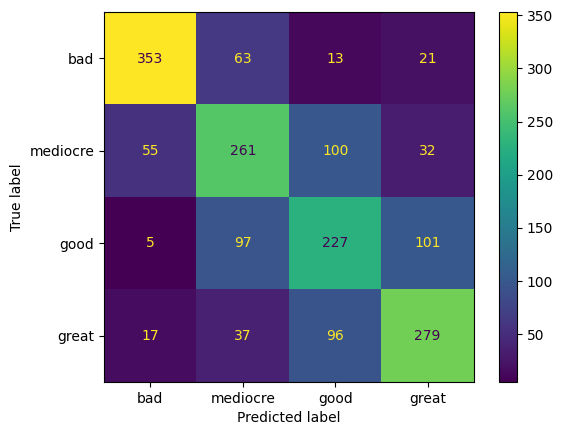

In [40]:
# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


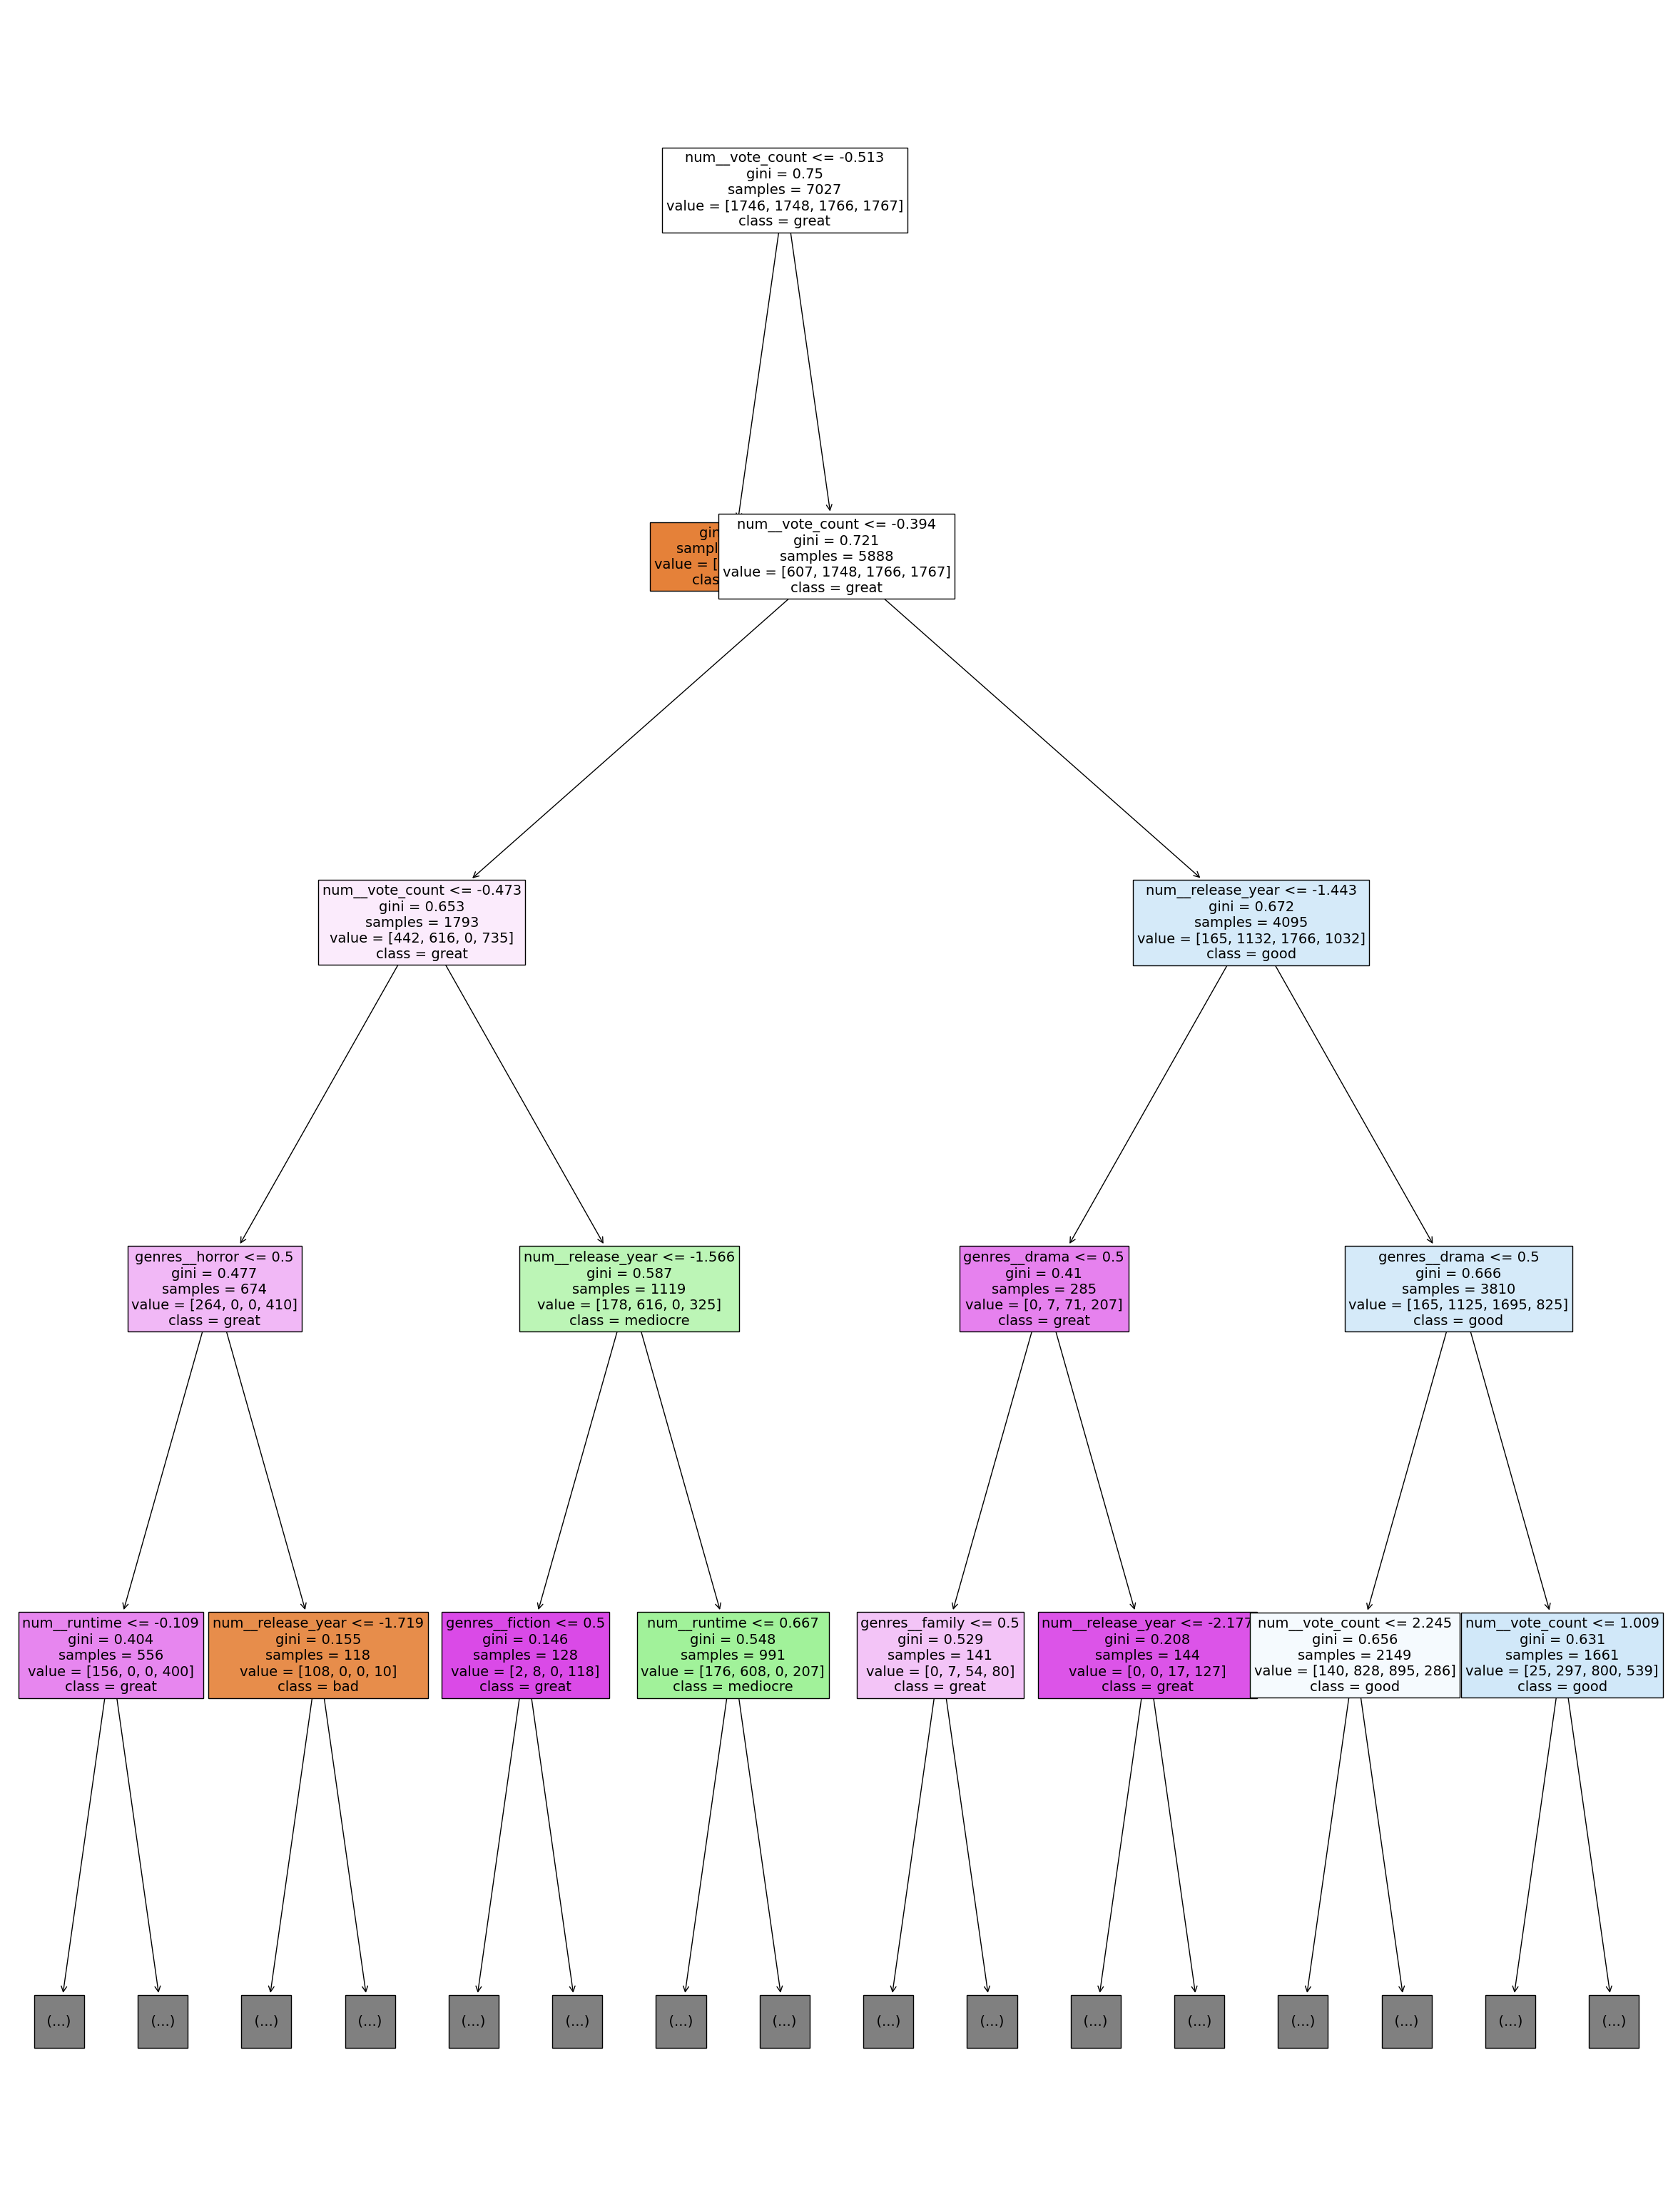

In [41]:

# Visualizing the decision tree with bigger rectangles and text
plt.figure(figsize=(30, 40)) 
plot_tree(cart_tree, 
          filled=True, 
          feature_names=feat_names, 
          class_names=label_encoder.classes_, 
          max_depth=4, 
          fontsize=14)  
plt.show()



In [42]:
# Writing the decision tree rules as text
tree_rules = export_text(cart_tree, feature_names=feat_names)
print(tree_rules)



|--- num__vote_count <= -0.51
|   |--- class: 0
|--- num__vote_count >  -0.51
|   |--- num__vote_count <= -0.39
|   |   |--- num__vote_count <= -0.47
|   |   |   |--- genres__horror <= 0.50
|   |   |   |   |--- num__runtime <= -0.11
|   |   |   |   |   |--- num__release_year <= -0.77
|   |   |   |   |   |   |--- num__popularity <= -0.22
|   |   |   |   |   |   |   |--- production_companies__orionpictures <= 0.50
|   |   |   |   |   |   |   |   |--- overview__finds <= 0.41
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- overview__finds >  0.41
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- production_companies__orionpictures >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- num__popularity >  -0.22
|   |   |   |   |   |   |   |--- num__vote_count <= -0.49
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- num__vote_count >  -0.49
|   |   |   |   |   |  

In [43]:
# Feature importance
importances = pd.Series(cart_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Important Features:\n", importances.head(10))

Top 10 Important Features:
 num__vote_count              0.362074
num__release_year            0.070064
num__runtime                 0.048158
num__popularity              0.031859
num__budget                  0.030163
num__revenue                 0.024358
genres__drama                0.020885
genres__horror               0.019437
cat__original_language_en    0.018001
num__release_month           0.015075
dtype: float64


### Complexity Measure of Base Model

In [44]:
# Calculate tree complexity
def calculate_tree_complexity(tree_model):
    n_nodes = tree_model.tree_.node_count
    n_leaves = sum(tree_model.tree_.children_left == -1)
    max_depth = tree_model.tree_.max_depth

    print(f"Number of nodes: {n_nodes}")
    print(f"Number of leaves: {n_leaves}")
    print(f"Maximum depth of the tree: {max_depth}")

    return n_nodes, n_leaves, max_depth

# Complexity for the non-tuned CART model
n_nodes, n_leaves, max_depth = calculate_tree_complexity(cart_tree)


Number of nodes: 2477
Number of leaves: 1239
Maximum depth of the tree: 44


#### Wrappers to  tune parameters

#### RandomizedSearchCV

In [45]:
"""
from sklearn.model_selection import RandomizedSearchCV

new_cart_tree = DecisionTreeClassifier(random_state=seed)


param_grid = {
    'criterion': ['gini', 'entropy'],  # Split quality
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
}

random_search = RandomizedSearchCV(estimator=new_cart_tree, 
                                   param_distributions=param_grid, 
                                   n_iter=500, 
                                   scoring='accuracy',
                                   cv=5, 
                                   verbose=1, 
                                   random_state=seed,
                                   n_jobs=-1)


random_search.fit(X_train, Y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

#Output: 
#Fitting 5 folds for each of 432 candidates, totalling 2160 fits, 720 fits failed out of a total of 2160.
#Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}
#Best Cross-Validation Score: 0.5776281619697989
"""


'\nfrom sklearn.model_selection import RandomizedSearchCV\n\nnew_cart_tree = DecisionTreeClassifier(random_state=seed)\n\n\nparam_grid = {\n    \'criterion\': [\'gini\', \'entropy\'],  # Split quality\n    \'max_depth\': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree\n    \'min_samples_split\': [2, 5, 10],  # Minimum samples required to split an internal node\n    \'min_samples_leaf\': [1, 2, 4, 6],  # Minimum samples required to be at a leaf node\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\'],  # Number of features to consider for the best split\n}\n\nrandom_search = RandomizedSearchCV(estimator=new_cart_tree, \n                                   param_distributions=param_grid, \n                                   n_iter=500, \n                                   scoring=\'accuracy\',\n                                   cv=5, \n                                   verbose=1, \n                                   random_state=seed,\n                                   n_job

In [46]:
# Best parameters from RandomizedSearchCV wrapper output
best_params = {
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10
}

new_cart_tree = DecisionTreeClassifier(random_state=seed, **best_params)

new_cart_tree.fit(X_train, Y_train)

Y_pred_new = new_cart_tree.predict(X_test)

In [47]:

accuracy = accuracy_score(Y_test, Y_pred_new)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5800


In [64]:
print(classification_report(Y_test, Y_pred_new, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.79      0.73      0.76       450
    mediocre       0.48      0.57      0.52       448
        good       0.44      0.41      0.42       430
       great       0.63      0.60      0.61       429

    accuracy                           0.58      1757
   macro avg       0.59      0.58      0.58      1757
weighted avg       0.59      0.58      0.58      1757



#### GridSearch

In [49]:

param_grid_search = {
    'max_depth': [5, 10, 15, 20, 25, 30, 40, 50, 60, 100, None],    
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8, 1],      
    'min_samples_split': [2, 3, 4, 5, 6, 8, 10, 15, 20],            
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 10],                    
    'criterion': ['gini', 'entropy'],                               
    'splitter': ['best', 'random']                                  
}



In [50]:
grid_search = GridSearchCV(
    estimator=cart_tree, 
    param_grid=param_grid_search, 
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, Y_train)

print("Best parameters:", grid_search.best_params_)

#Output:
#~36min
#Fitting 5 folds for each of 19404 candidates, totalling 97020 fits, 13860 fits failed out of a total of 97020.
#Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 15, 'splitter': 'best'}


In [52]:
best_params = {
    'criterion': 'entropy', 
    'max_depth': 10, 
    'max_features': 0.8, 
    'min_samples_leaf': 5, 
    'min_samples_split': 15, 
    'splitter': 'best'
}

best_cart_model = DecisionTreeClassifier(**best_params, random_state=seed)


best_cart_model.fit(X_train, Y_train)
Y_pred_best = best_cart_model.predict(X_test)

In [53]:
accuracy = accuracy_score(Y_test, Y_pred_best)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6574


In [63]:
print(classification_report(Y_test, Y_pred_best, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.96      0.77      0.85       450
    mediocre       0.58      0.66      0.62       448
        good       0.49      0.61      0.54       430
       great       0.72      0.59      0.64       429

    accuracy                           0.66      1757
   macro avg       0.69      0.66      0.66      1757
weighted avg       0.69      0.66      0.67      1757



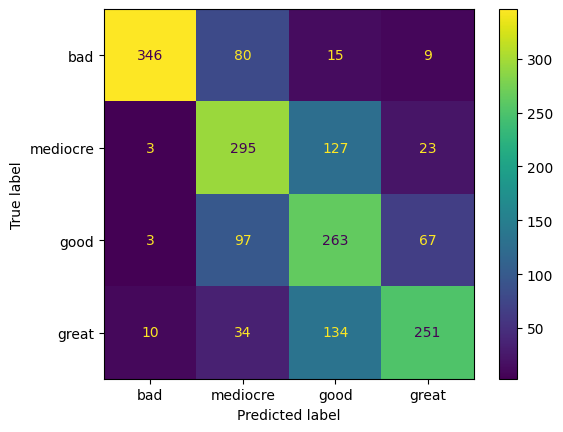

In [55]:
# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


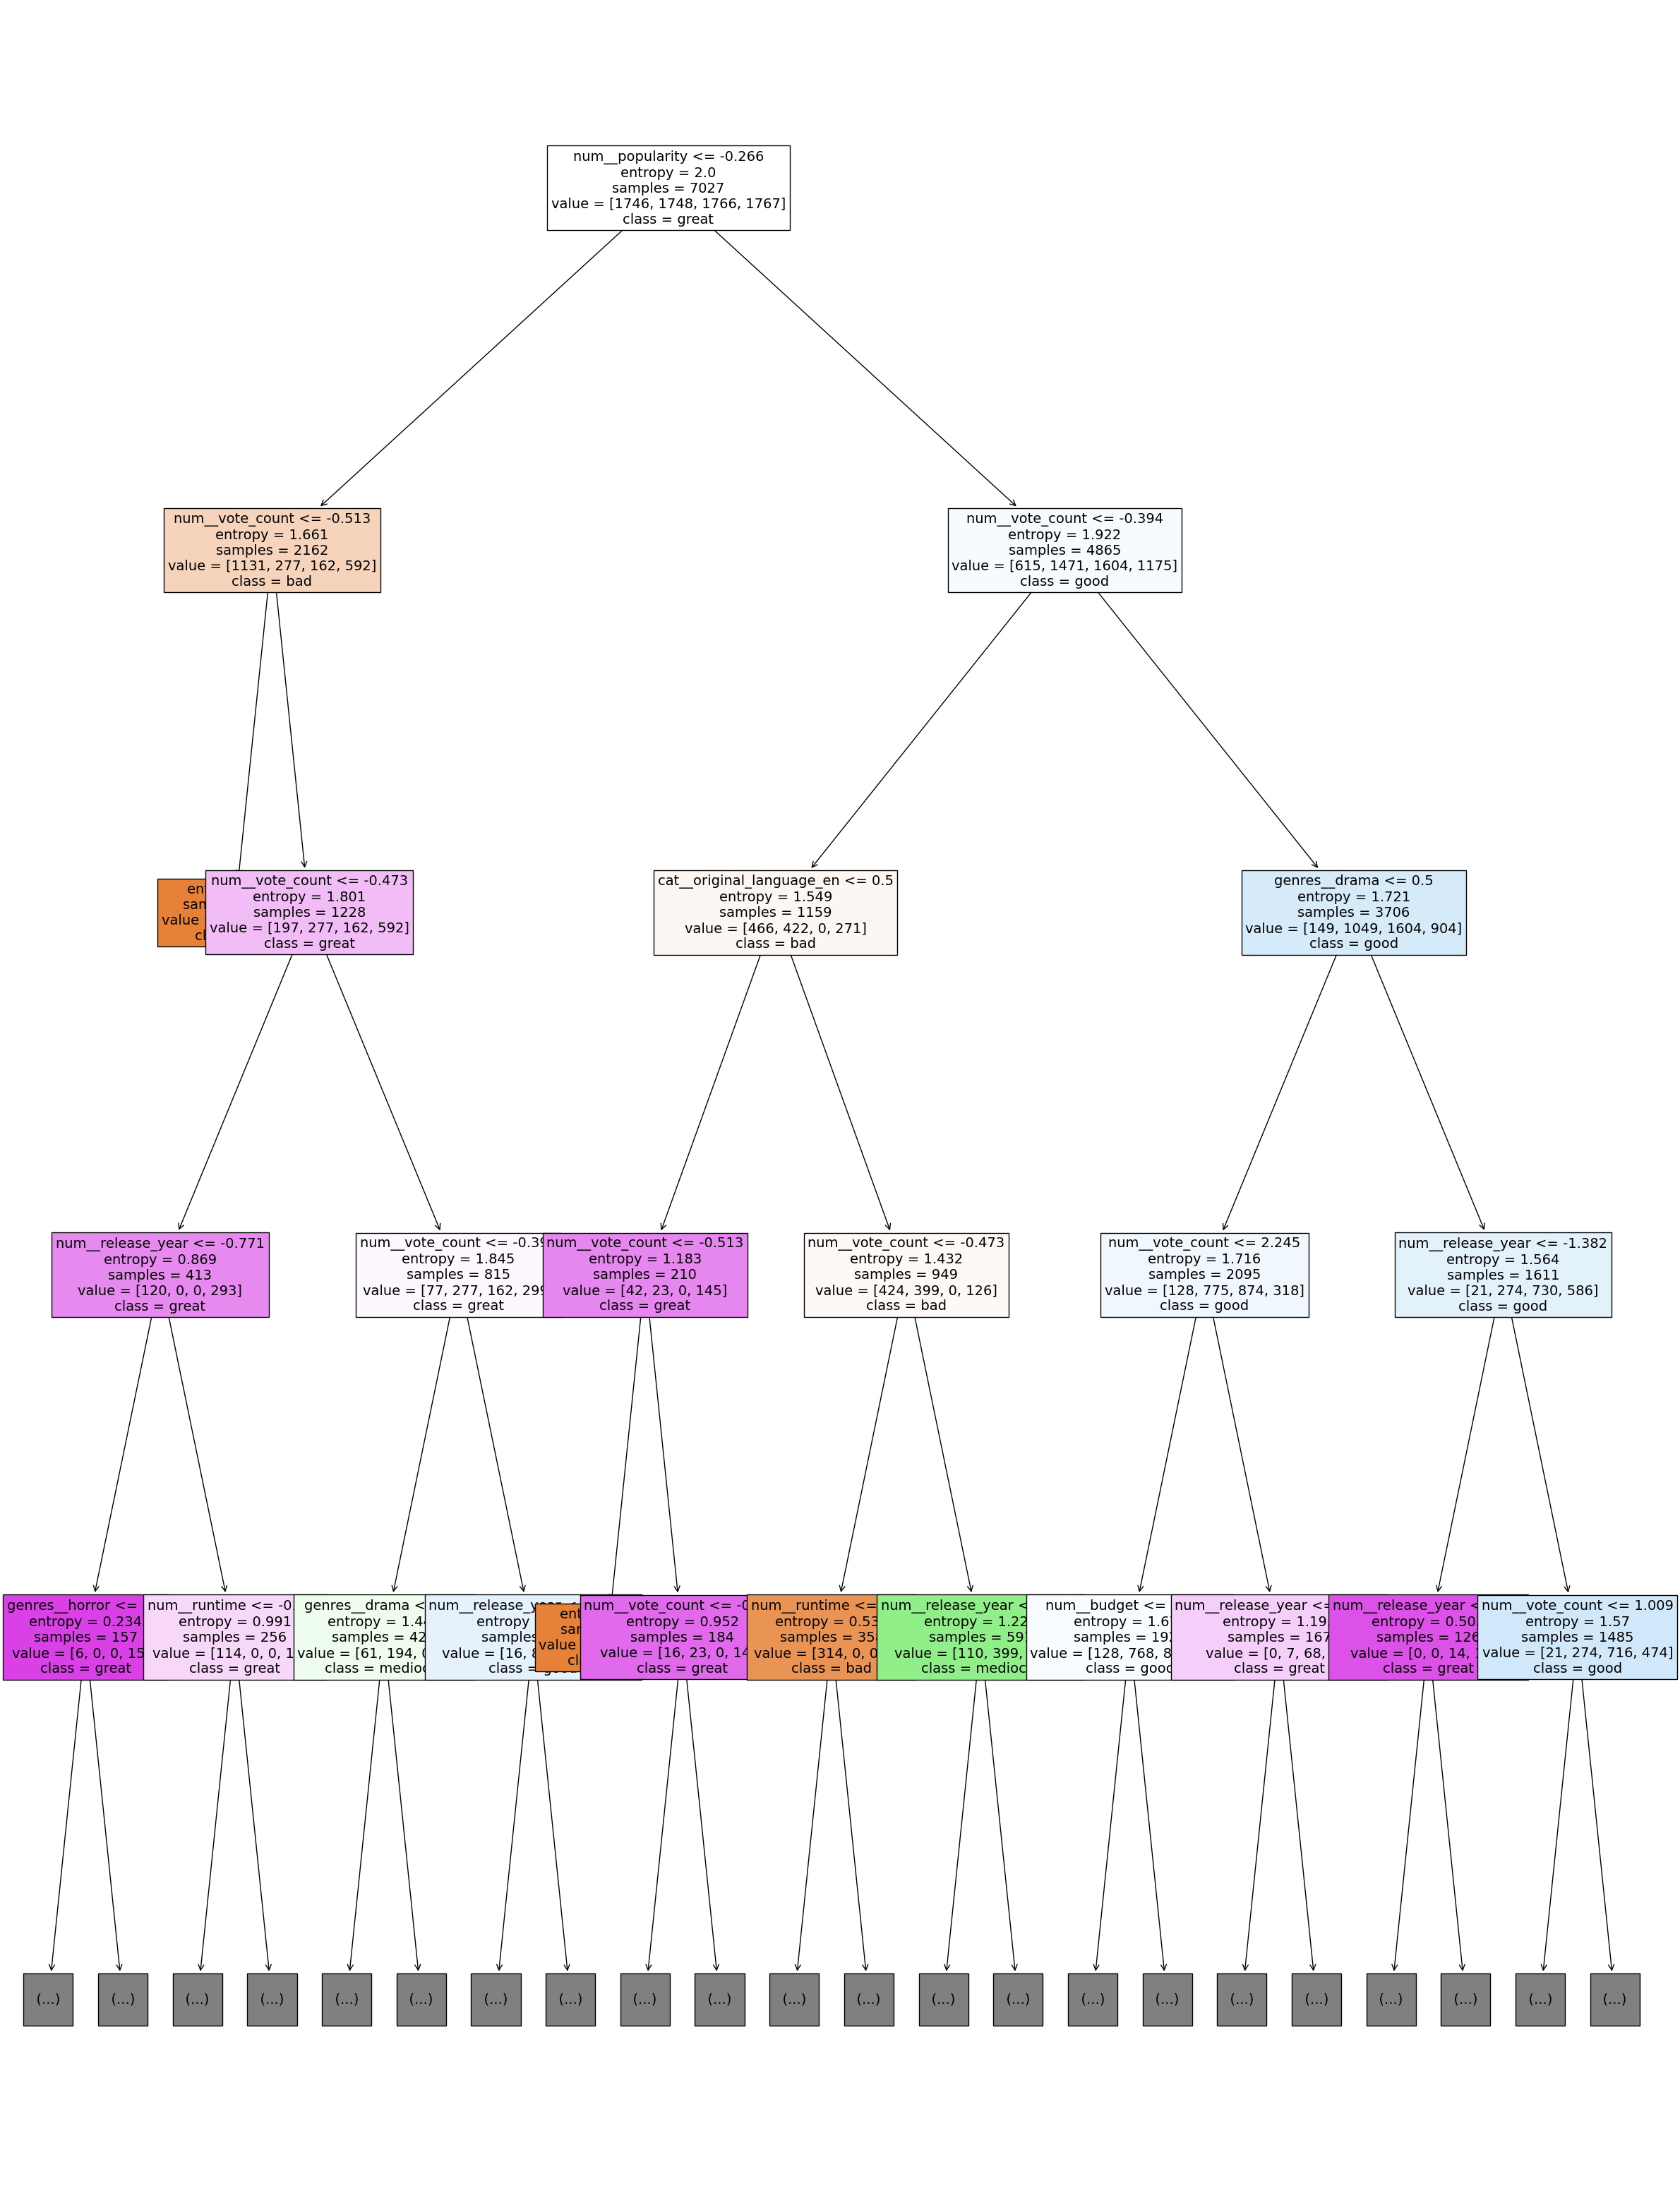

In [56]:

plt.figure(figsize=(30, 40)) 
plot_tree(best_cart_model, 
          filled=True, 
          feature_names=feat_names, 
          class_names=label_encoder.classes_, 
          max_depth=4, 
          fontsize=14)  
plt.show()


In [57]:
tree_rules = export_text(best_cart_model, feature_names=feat_names)
print(tree_rules)

|--- num__popularity <= -0.27
|   |--- num__vote_count <= -0.51
|   |   |--- class: 0
|   |--- num__vote_count >  -0.51
|   |   |--- num__vote_count <= -0.47
|   |   |   |--- num__release_year <= -0.77
|   |   |   |   |--- genres__horror <= 0.50
|   |   |   |   |   |--- genres__family <= 0.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- genres__family >  0.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |--- genres__horror >  0.50
|   |   |   |   |   |--- class: 3
|   |   |   |--- num__release_year >  -0.77
|   |   |   |   |--- num__runtime <= -0.11
|   |   |   |   |   |--- genres__documentary <= 0.50
|   |   |   |   |   |   |--- genres__horror <= 0.50
|   |   |   |   |   |   |   |--- num__runtime <= -1.15
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- num__runtime >  -1.15
|   |   |   |   |   |   |   |   |--- genres__drama <= 0.50
|   |   |   |   |   |   |   |   |   |--- num__vote_count <= -0.51
|   |   |   |   |   |   |   |  

Top 10 Important Features (Tuned Model):
 num__vote_count              0.499748
num__popularity              0.150682
num__release_year            0.084583
num__runtime                 0.049306
genres__drama                0.044136
num__budget                  0.041354
cat__original_language_en    0.040282
genres__documentary          0.020537
genres__horror               0.011141
num__revenue                 0.007158
dtype: float64


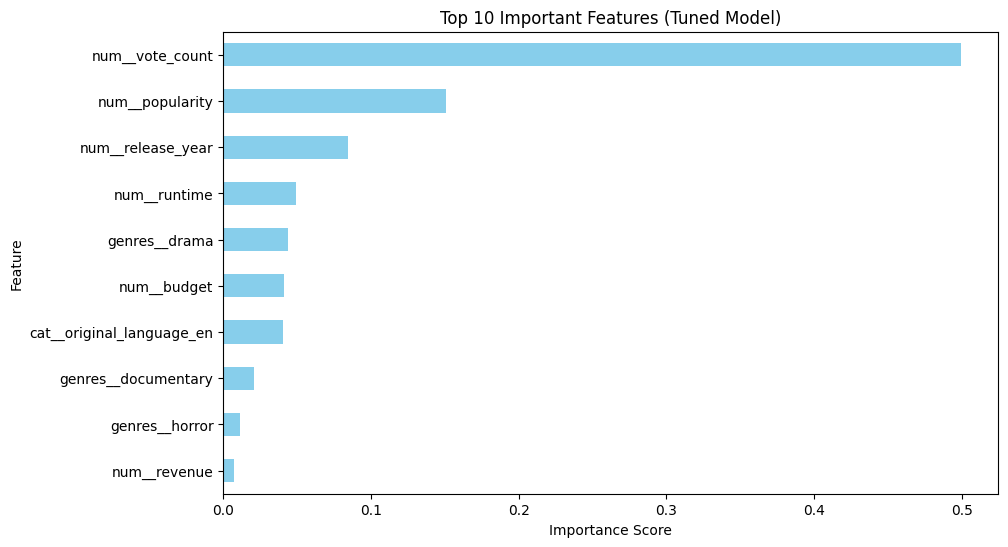

In [58]:
# Feature importance for the tuned model
best_importances = pd.Series(best_cart_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display the top 10 most important features
print("Top 10 Important Features (Tuned Model):\n", best_importances.head(10))

# Visualize the feature importances
plt.figure(figsize=(10, 6))
best_importances.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Important Features (Tuned Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


### Complexity Measure of Tuned Model

In [59]:
# Complexity for the best CART model
n_nodes, n_leaves, max_depth = calculate_tree_complexity(best_cart_model)


Number of nodes: 437
Number of leaves: 219
Maximum depth of the tree: 10
